# Deep Learning Assignment - 02 , Set - 5 

## Problem - 01, Group - 029

## Image Captionining

## Library Imports

In [1]:
import os
from os import listdir
import progressbar
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime
from collections import Counter
from collections import OrderedDict
from nltk.translate.bleu_score import sentence_bleu

import warnings
import os
warnings.simplefilter("ignore")

import tensorflow as tf
from sklearn.model_selection import train_test_split



2021-09-19 20:42:19.034451: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


## Validate GPU Availability

In [2]:
# Note this code is only valid if GPU is being used for training

# Before we run the parameter tuning, we will work with gpu memory allocation
# we will only use that much of memory of gpu as it is needed - allow the growth of gpu memory as it is needed
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
else:
    print("No GPU Available, switching to CPU Version")

1 Physical GPUs, 1 Logical GPUs


2021-09-19 20:42:19.817058: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-19 20:42:19.817646: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-19 20:42:19.871512: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-19 20:42:19.871876: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2070 SUPER computeCapability: 7.5
coreClock: 1.83GHz coreCount: 40 deviceMemorySize: 7.78GiB deviceMemoryBandwidth: 417.29GiB/s
2021-09-19 20:42:19.871903: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-09-19 20:42:19.873263: I tensorflow/stream_executor/platfo

## Data Visualization and Augmentation

In [3]:
# Read the pickle file

import pickle
with open('../../../LargeDatasets/CNNDatasets/ImageCaptioning/set_0.pkl', 'rb') as f:
    imagelist = pickle.load(f)

In [4]:
# From the pickle list loaded, we will populate a dataframe

imageframe = pd.DataFrame(columns=["CaptionID", "ImageName", "Caption"])

for index in range(len(imagelist)):
    string = imagelist[index]
    splitparts = string.split("\t")
    subparts = splitparts[0].split("#")
    rowDict = {'CaptionID': subparts[1], 'ImageName': subparts[0], 'Caption': splitparts[1]}
    imageframe = imageframe.append(rowDict, ignore_index=True)

# Check the initial rows after dataframe populate
imageframe.head()


,CaptionID,ImageName,Caption
0,4,318667317_108c402140.jpg,A man in a black hoodie be hold a paper sign .
1,4,2072574835_febf0c5fb9.jpg,Three race dog be run out of the start gate on...
2,4,3083016677_5782bc337c.jpg,Two motorcycle with two rider each .
3,0,95734038_2ab5783da7.jpg,A man on a bike nest to a river .
4,1,241346146_f27759296d.jpg,A football player try tackle another player wh...


In [5]:
# Check few unique information from the dataframe

print(f"Number of Unique captionID - {imageframe['CaptionID'].nunique()}")
print(f"Number of Unique Images - {imageframe['ImageName'].nunique()}")

Number of Unique captionID - 5
Number of Unique Images - 8037


In [6]:
# Read the actual images directory

dir_images = '../../../LargeDatasets/CNNDatasets/ImageCaptioning/Flicker8k_Dataset'

images = os.listdir(dir_images)
print(f"Number of images in the directory - {len(images)}")

Number of images in the directory - 8091


### Plotting few images with captions

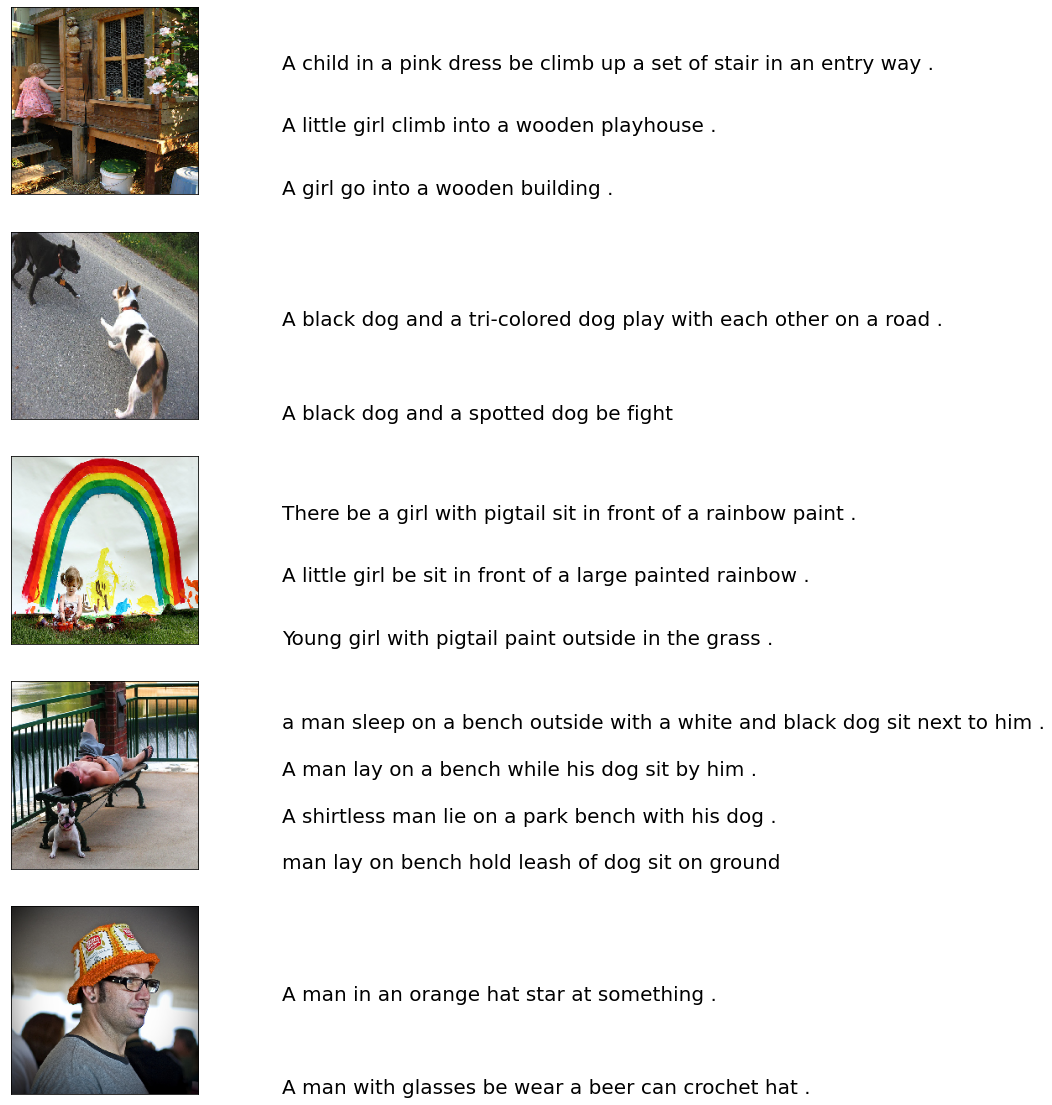

In [7]:
# Define the target size for image pre-processing

target_size = (224,224,3)

count = 1
fig = plt.figure(figsize=(10,20))

filenames = np.unique(imageframe.ImageName.values)

for item in np.unique(imageframe.ImageName.values)[:5]:
    filename = dir_images + '/' + item
    captions = list(imageframe["Caption"].loc[imageframe["ImageName"] == item].values)
    image_load = tf.keras.preprocessing.image.load_img(filename, target_size=target_size)
        
    ax = fig.add_subplot(5,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1
    
    ax = fig.add_subplot(5,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    count += 1
plt.show()

We will define a function to build the vocabulary from the captions and identify most common occurring 50 words

In [8]:
# Function to buid the vocabulary

def df_word(df_txt):
    vocabulary = []
    for i in range(len(df_txt)):
        temp=df_txt.iloc[i,2]
        vocabulary.extend(temp.split())
    print('Vocabulary Size: %d' % len(set(vocabulary)))
    ct = Counter(vocabulary)

    # We will build the dictionary of words and values
    dfword = pd.DataFrame({"word":list(ct.keys()),"count":list(ct.values())})
    dfword = dfword.sort_values("count",ascending=False)
    dfword = dfword.reset_index()[["word","count"]]
    return(dfword)

Vocabulary Size: 6028


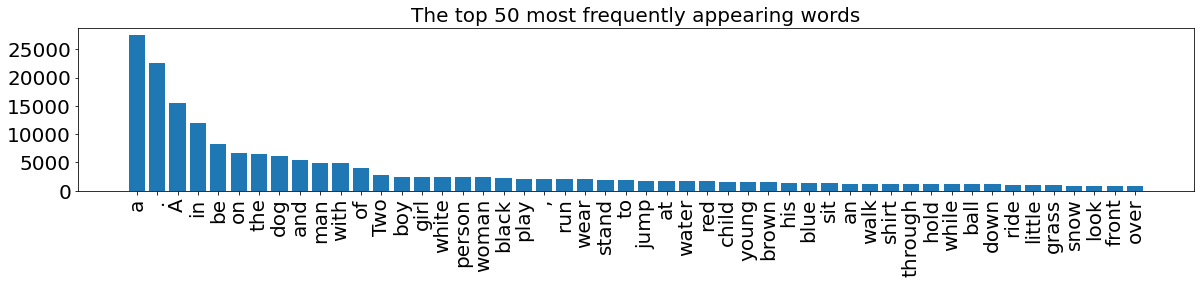

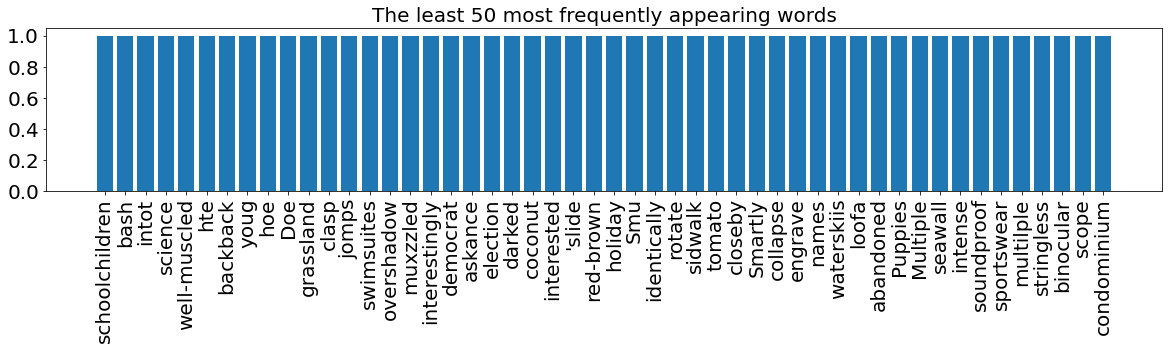

In [9]:
topn = 50
dfword = df_word(imageframe)

# Graphic visualizations of the most commonly occuring words

def plthist(dfsub, title="The top 50 most frequently appearing words"):
    plt.figure(figsize=(20,3))
    plt.bar(dfsub.index,dfsub["count"])
    plt.yticks(fontsize=20)
    plt.xticks(dfsub.index,dfsub["word"],rotation=90,fontsize=20)
    plt.title(title,fontsize=20)
    plt.show()

plthist(dfword.iloc[:topn,:],
        title="The top 50 most frequently appearing words")
plthist(dfword.iloc[-topn:,:],
        title="The least 50 most frequently appearing words")

## Data Preparation for Model Building

### We will perform text cleaning and text preprocessing on the captions set

In [10]:
import string

# function to remove punctuations
def remove_punctuation(text_original):
    text_no_punctuation = text_original.translate(str.maketrans('','',string.punctuation))
    return(text_no_punctuation)

# We will not consider single characters
def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)

# Removal of numerics
def remove_numeric(text,printTF=False):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if printTF:
            print("    {:10} : {:}".format(word,isalpha))
        if isalpha:
            text_no_numeric += " " + word
    return(text_no_numeric)

# Main function which will include all previous three
def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    return(text)


In [11]:
# Perform the cleaning on the Captions

for i, caption in enumerate(imageframe.Caption.values):
    newcaption = text_clean(caption)
    imageframe["Caption"].iloc[i] = newcaption

In [12]:
# Now we will add some start and close tag to identify the beginning and end of the caption

def add_start_end_seq_token(captions):
    caps = []
    for txt in captions:
        txt = 'starttag ' + txt + ' endtag'
        caps.append(txt)
    return(caps)

imageframe["Caption"] = add_start_end_seq_token(imageframe["Caption"])
imageframe.head(5)

,CaptionID,ImageName,Caption
0,4,318667317_108c402140.jpg,starttag man in black hoodie be hold paper si...
1,4,2072574835_febf0c5fb9.jpg,starttag Three race dog be run out of the sta...
2,4,3083016677_5782bc337c.jpg,starttag Two motorcycle with two rider each e...
3,0,95734038_2ab5783da7.jpg,starttag man on bike nest to river endtag
4,1,241346146_f27759296d.jpg,starttag football player try tackle another p...


## Building the Model

In [13]:
# Examine the model - We would use VGG16 model as per the directions of the assignment

modelvgg = tf.keras.applications.VGG16(include_top=True)
# Check the summary
modelvgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [14]:
# Instantiate the model
modelvgg.layers.pop()
modelvgg = tf.keras.models.Model(inputs=modelvgg.inputs, outputs=modelvgg.layers[-1].output)

# Check the model summary
modelvgg.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Prepare the data - Build the numpy pixels array

In [15]:
images = OrderedDict()
jpgs = os.listdir(dir_images)

with progressbar.ProgressBar(max_value=len(jpgs)) as bar:
    for index,name in enumerate(jpgs):
        
        # load an image from file
        filename = dir_images + '/' + name
        image = tf.keras.preprocessing.image.load_img(filename, target_size=target_size)

        # convert the image pixels to a numpy array
        image = tf.keras.preprocessing.image.img_to_array(image)

        # Using the VGG16 model to preprocess the images
        nimage = tf.keras.applications.vgg16.preprocess_input(image)

        # VGG16 model runs the prediction (feature extraction)
        y_pred = modelvgg.predict(nimage.reshape( (1,) + nimage.shape[:3]))

        # We will flatten the output
        images[name] = y_pred.flatten()
        bar.update(index)


2021-09-19 20:43:03.884691: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-19 20:43:03.907408: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3600000000 Hz
2021-09-19 20:43:04.018797: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-09-19 20:43:04.155419: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2021-09-19 20:43:04.936485: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2021-09-19 20:43:04.967805: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
100% (8091 of 8091) |####################| Elap

In [16]:
dimages, keepindex = [],[]

nd=(imageframe.CaptionID.values)
b = [(int(i)==0) for i in nd]

imageframe = imageframe.loc[imageframe["CaptionID"].values == "0",: ]

for i, fnm in enumerate(imageframe.ImageName):
    if fnm in images.keys():
        dimages.append(images[fnm])
        keepindex.append(i)
        
fnames = imageframe["ImageName"].iloc[keepindex].values
dcaptions = imageframe["Caption"].iloc[keepindex].values

dimages = np.array(dimages)
print(imageframe["CaptionID"][:5])

3     0
10    0
13    0
21    0
23    0
Name: CaptionID, dtype: object


### Build the Tokenizer and Build the vocabulary from the Caption set

In [17]:
## the maximum number of words in dictionary
count_words=22000

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=8000)
tokenizer.fit_on_texts(dcaptions)
vocab_size = len(tokenizer.word_index) + 1
print("vocabulary size : {}".format(vocab_size))

dtexts = tokenizer.texts_to_sequences(dcaptions)
print(dtexts[:5])

vocabulary size : 2785
[[1, 9, 6, 70, 1482, 21, 302, 2], [1, 14, 32, 13, 127, 4, 98, 11, 510, 359, 3, 8, 128, 2], [1, 645, 232, 27, 3, 878, 292, 132, 135, 2], [1, 120, 54, 209, 8, 38, 2], [1, 184, 645, 232, 5, 23, 3, 8, 43, 11, 115, 3, 72, 62, 2]]


In [18]:
# find the max length of a caption
maxlen = np.max([len(text) for text in dtexts])
maxlen

28

### Train-Test and Validation Split

In [19]:
# We will consider 20% proportion in both test and validation sets

test_proportions , validation_proportions = 0.2, 0.2 

# count the vocab which has been built earlier
N = len(dtexts)

Ntest, Nval = int(N*test_proportions), int(N*validation_proportions)

def performSplit(dtexts,Ntest,Nval):
    return(dtexts[:Ntest], 
           dtexts[Ntest:Ntest+Nval],  
           dtexts[Ntest+Nval:])

dt_test,  dt_val, dt_train   = performSplit(dtexts,Ntest,Nval)
di_test,  di_val, di_train   = performSplit(dimages,Ntest,Nval)
fnm_test,fnm_val, fnm_train  = performSplit(fnames,Ntest,Nval)

### Pre-process the data before training

In [20]:
# Preprocessing the images using keras preprocessing - This pre-processed image will go for training

def preprocessing(dtexts,dimages):
    N = len(dtexts)
    print("# captions/images = {}".format(N))

    assert(N==len(dimages))
    Xtext, Ximage, ytext = [],[],[]
    for text,image in zip(dtexts,dimages):

        for i in range(1,len(text)):
            in_text, out_text = text[:i], text[i]
            in_text = tf.keras.preprocessing.sequence.pad_sequences([in_text],maxlen=maxlen).flatten()
            out_text = tf.keras.utils.to_categorical(out_text,num_classes = vocab_size)

            Xtext.append(in_text)
            Ximage.append(image)
            ytext.append(out_text)

    Xtext  = np.array(Xtext)
    Ximage = np.array(Ximage)
    ytext  = np.array(ytext)
    print(" {} {} {}".format(Xtext.shape,Ximage.shape,ytext.shape))
    return(Xtext,Ximage,ytext)


Xtext_train, Ximage_train, ytext_train = preprocessing(dt_train,di_train)
Xtext_val,   Ximage_val,   ytext_val   = preprocessing(dt_val,di_val)


# captions/images = 3010
 (30400, 28) (30400, 1000) (30400, 2785)
# captions/images = 1002
 (10105, 28) (10105, 1000) (10105, 2785)


## Training the model

In [21]:
dim_embedding = 64

input_image = tf.keras.layers.Input(shape=(Ximage_train.shape[1],))
fimage = tf.keras.layers.Dense(256,activation=tf.keras.activations.relu,name="ImageFeature")(input_image)

## sequence model
input_txt = tf.keras.layers.Input(shape=(maxlen,))
ftxt = tf.keras.layers.Embedding(vocab_size,dim_embedding, mask_zero=True)(input_txt)
ftxt = tf.keras.layers.LSTM(256,name="CaptionFeature")(ftxt)

## combined model for decoder
decoder = tf.keras.layers.add([ftxt,fimage])
decoder = tf.keras.layers.Dense(256,activation=tf.keras.activations.relu, activity_regularizer=tf.keras.regularizers.L2(0.001))(decoder)
decoder = tf.keras.layers.Dense(256,activation=tf.keras.activations.relu, activity_regularizer=tf.keras.regularizers.L2(0.001))(decoder)
decoder = tf.keras.layers.Dense(256,activation=tf.keras.activations.relu, activity_regularizer=tf.keras.regularizers.L2(0.001))(decoder)

# We will add the dropout layer just before the output
decoder = tf.keras.layers.Dropout(0.5) (decoder)
output = tf.keras.layers.Dense(vocab_size,activation=tf.keras.activations.softmax)(decoder)
model = tf.keras.models.Model(inputs=[input_image, input_txt],outputs=output)

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam())

print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 28, 64)       178240      input_3[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1000)]       0                                            
__________________________________________________________________________________________________
CaptionFeature (LSTM)           (None, 256)          328704      embedding[0][0]                  
____________________________________________________________________________________________

In [22]:
# We will conduct the training

start = datetime.now()

hist = model.fit([Ximage_train, Xtext_train], ytext_train, 
                  epochs=20, verbose=2, 
                  batch_size=64,
                  validation_data=([Ximage_val, Xtext_val], ytext_val))

end = datetime.now()

print(f"Training time - {end-start}")

Epoch 1/20
475/475 - 10s - loss: 5.6026 - val_loss: 5.1297
Epoch 2/20
475/475 - 8s - loss: 4.8653 - val_loss: 4.7160
Epoch 3/20
475/475 - 8s - loss: 4.5038 - val_loss: 4.5568
Epoch 4/20
475/475 - 8s - loss: 4.2764 - val_loss: 4.4702
Epoch 5/20
475/475 - 8s - loss: 4.1020 - val_loss: 4.4838
Epoch 6/20
475/475 - 8s - loss: 3.9622 - val_loss: 4.4630
Epoch 7/20
475/475 - 8s - loss: 3.8250 - val_loss: 4.5361
Epoch 8/20
475/475 - 9s - loss: 3.7108 - val_loss: 4.5485
Epoch 9/20
475/475 - 8s - loss: 3.5974 - val_loss: 4.6194
Epoch 10/20
475/475 - 8s - loss: 3.4904 - val_loss: 4.6492
Epoch 11/20
475/475 - 8s - loss: 3.3852 - val_loss: 4.7359
Epoch 12/20
475/475 - 8s - loss: 3.2788 - val_loss: 4.7885
Epoch 13/20
475/475 - 8s - loss: 3.1686 - val_loss: 5.0783
Epoch 14/20
475/475 - 8s - loss: 3.0691 - val_loss: 5.1023
Epoch 15/20
475/475 - 9s - loss: 2.9661 - val_loss: 5.1432
Epoch 16/20
475/475 - 9s - loss: 2.8677 - val_loss: 5.4792
Epoch 17/20
475/475 - 8s - loss: 2.7637 - val_loss: 5.6674
Epoch

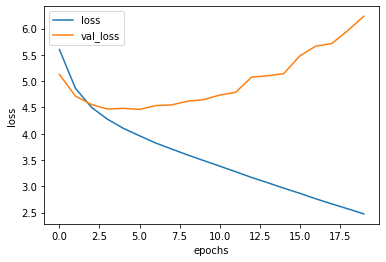

In [23]:
# Examine the training vs validation loss

for label in ["loss","val_loss"]:
    plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

It is evident that model has overfitted, lets check how it does on the predictions

### Run the predictions

In [24]:
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])

# function to predict the captions

def predict_caption(image):
    '''
    image.shape = (1,4462)
    '''

    in_text = 'starttag'

    for iword in range(maxlen):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = tf.keras.preprocessing.sequence.pad_sequences([sequence],maxlen)
        yhat = model.predict([image,sequence],verbose=0)
        yhat = np.argmax(yhat)
        newword = index_word[yhat]
        in_text += " " + newword
        if newword == "endtag":
            break
    return(in_text)

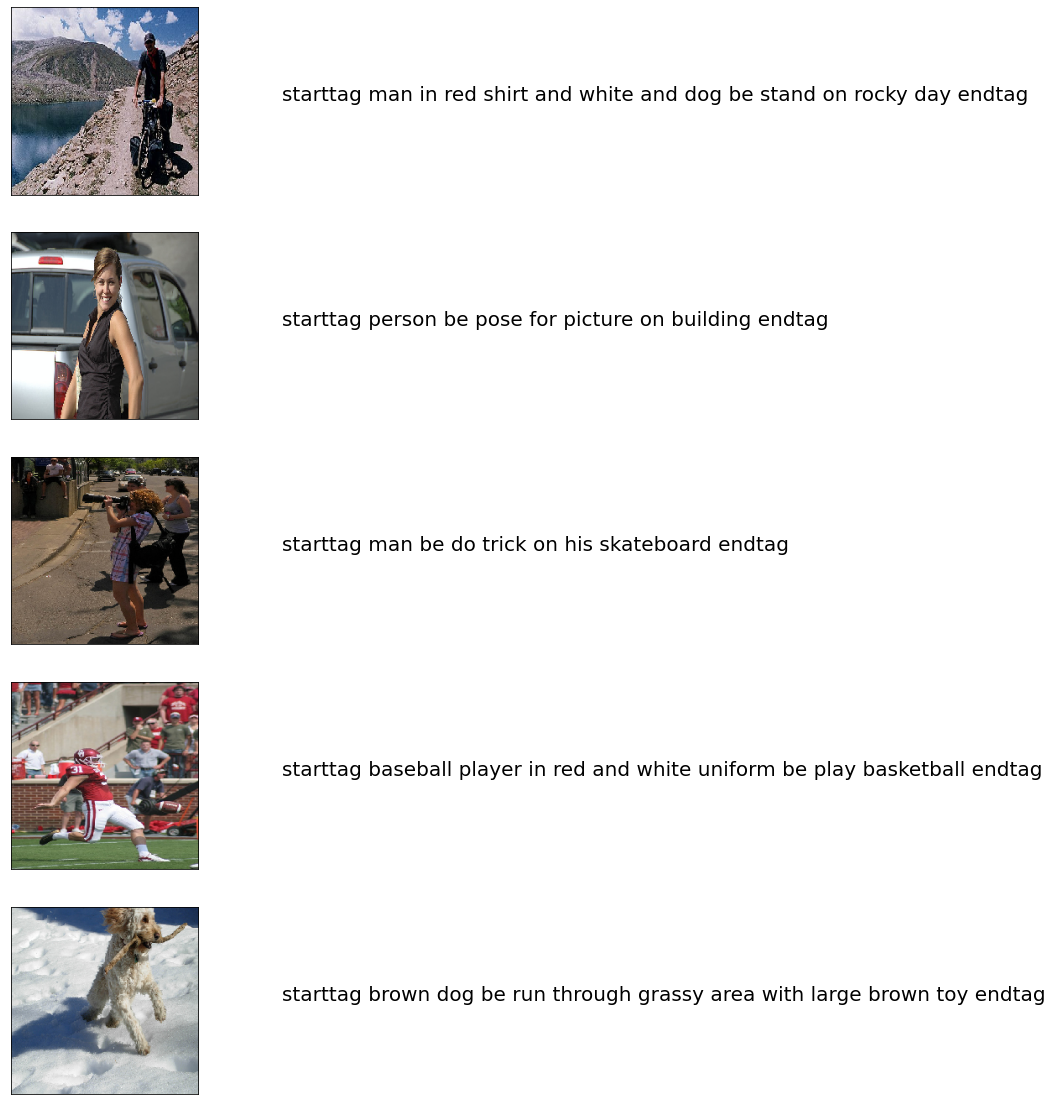

In [25]:
npic = 5
npix = 224
target_size = (npix,npix,3)

count = 1 # We start from the first image

fig = plt.figure(figsize=(10,20))
for jpgfnm, image_feature in zip(fnm_test[:npic],di_test[:npic]):
    
    ## take the images 
    filename = dir_images + '/' + jpgfnm
    image_load = tf.keras.preprocessing.image.load_img(filename, target_size=target_size)
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1

    ## predict the captions
    caption = predict_caption(image_feature.reshape(1,len(image_feature)))
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.text(0,0.5,caption,fontsize=20)
    count += 1

plt.show()

## Evaluating the Model

### Using Bleu score to evaluate the text generated

#### Bleu score can be used to for comparing a candidate text generation to one more reference text generations. 

#### So the model generated caption bleu score will be compared against the actual bleu score and compare the closeness of prediction

In [26]:
'''
We will seggregate images with

bad prediction - blue score less than 0.4
good prediction - bleu score greater than 0.6

'''

index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])

nkeep = 5
pred_good, pred_bad, bleus = [], [], [] 
count = 0 
for jpgfnm, image_feature, tokenized_text in zip(fnm_test,di_test,dt_test):
    count += 1
    if count % 200 == 0:
        print("  {:4.2f}% is done..".format(100*count/float(len(fnm_test))))
    
    caption_true = [ index_word[i] for i in tokenized_text ]     
    caption_true = caption_true[1:-1] ## remove startreg, and endreg
    
    ## captions
    caption = predict_caption(image_feature.reshape(1,len(image_feature)))
    caption = caption.split()
    
    ## remove starttag, and endtag
    caption = caption[1:-1]
    
    bleu = sentence_bleu([caption_true],caption)
    bleus.append(bleu)
    if bleu > 0.6 and len(pred_good) < nkeep:
        pred_good.append((bleu,jpgfnm,caption_true,caption))
    elif bleu < 0.4 and len(pred_bad) < nkeep:
        pred_bad.append((bleu,jpgfnm,caption_true,caption))

  19.96% is done..
  39.92% is done..
  59.88% is done..
  79.84% is done..
  99.80% is done..


In [27]:
'''
The function will be used to plot images with good and bad bleu score

good , bleu score > 0.6
bad, bleu score < 0.4
'''

def plot_images(pred_bad):
    def create_str(caption_true):
        strue = ""
        for s in caption_true:
            strue += " " + s
        return(strue)
    npix = 224
    target_size = (npix,npix,3)    
    count = 1
    fig = plt.figure(figsize=(10,20))
    npic = len(pred_bad)
    for pb in pred_bad:
        bleu,jpgfnm,caption_true,caption = pb
        ## images 
        filename = dir_images + '/' + jpgfnm
        image_load = tf.keras.preprocessing.image.load_img(filename, target_size=target_size)
        ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        caption_true = create_str(caption_true)
        caption = create_str(caption)
        
        ax = fig.add_subplot(npic,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.text(0,0.7,"true:" + caption_true,fontsize=20)
        ax.text(0,0.4,"pred:" + caption,fontsize=20)
        ax.text(0,0.1,"BLEU: {}".format(bleu),fontsize=20)
        count += 1
    plt.show()

Captions with lower Bleu scores


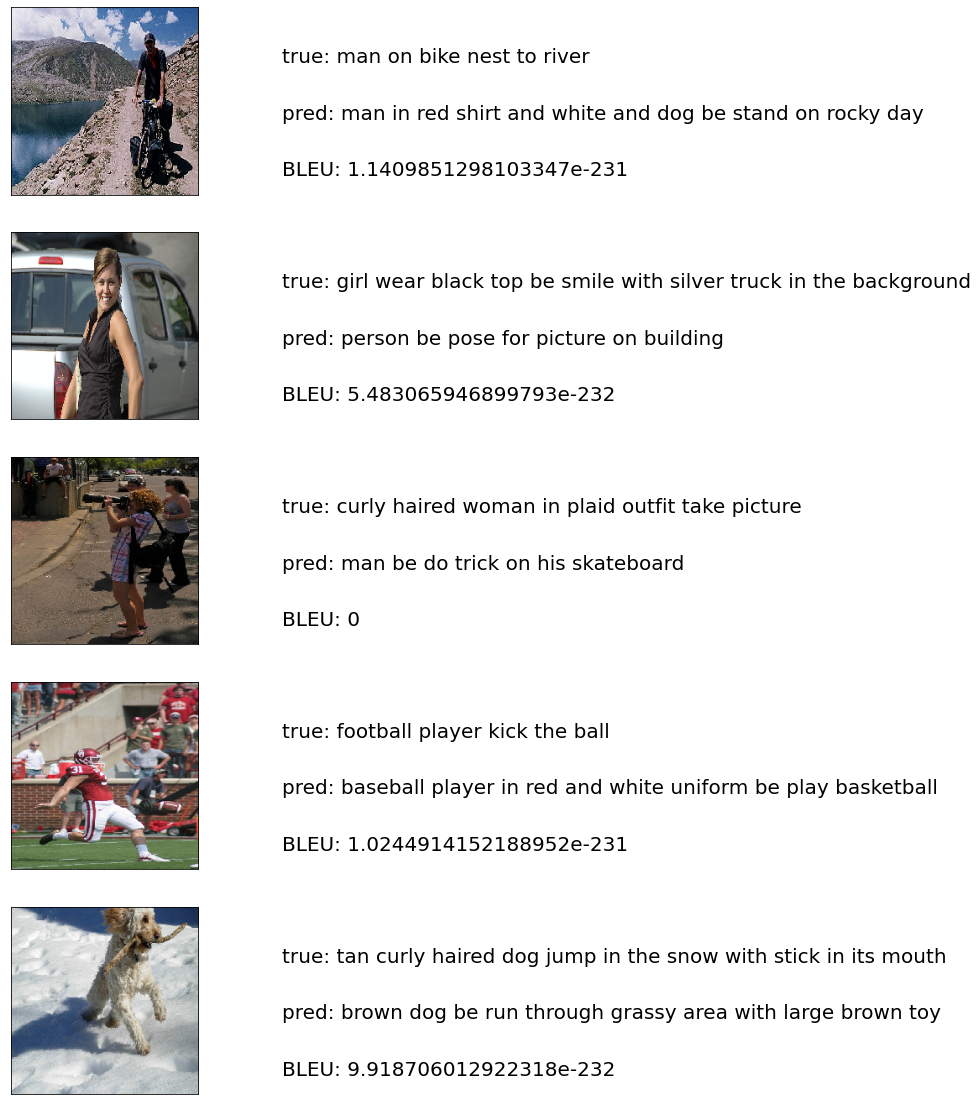

In [28]:
# Plotting the images which has bad caption generated as per the bleu score

print("Captions with lower Bleu scores")
plot_images(pred_bad)

Captions with Higher Bleu Scores


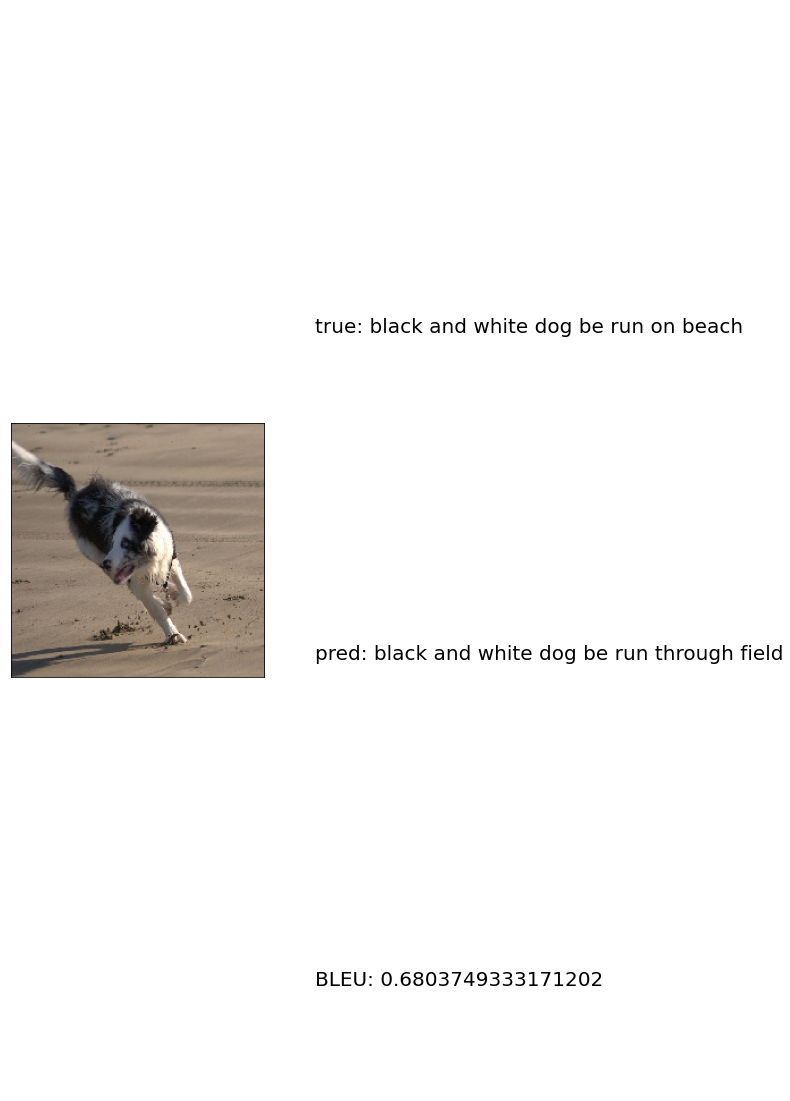

In [29]:
# Plotting the images which has good caption generated as per the bleu score

print("Captions with Higher Bleu Scores")
plot_images(pred_good)